In [4]:
import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier as XGB
import xgboost as xgb

from scipy.stats import uniform, randint
from gensim.models import Word2Vec

from sklearn.metrics import classification_report

In [5]:
df = pd.read_csv("original_data.csv")

In [6]:
df

,id,movie_name,synopsis,genre
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy
1,50185,Entity Project,A director and her friends renting a haunted h...,horror
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action
...,...,...,...,...
53995,80325,Untitled Monkeyshine/Ugly Brother Project,Two loser pest control buddies find themselves...,scifi
53996,84712,The Great Swindle,A seductive woman gets involved in relationshi...,thriller
53997,69801,When Men Get Pregnant,"Duyen, a wedding dress staff, who decides to c...",romance
53998,7678,Suttu Pidikka Utharavu,The people of a crowded colony in Coimbatore c...,action


In [7]:
from sklearn.model_selection import train_test_split

#train/test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['genre'])
#df_train.shape

#train/validation split
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=1, stratify=df_train['genre'])
#df_val.shape



In [8]:
# preprocess of train
df_train, x_train  = functions.preprocessing(df=df_train, remove_useless_sentences = True, is_train = True, tokenize=True, remove_one_characters=True, lemmatize=True, remove_stop_words=True)
y_train = functions.target_variable(df_train, 'genre')

[nltk_data] Downloading package wordnet to /Users/mac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-12-10 09:49:58.687570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package omw-1.4 to /Users/mac/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
#x_train

In [10]:
# preprocess test
df_test, x_test = functions.preprocessing(df=df_test, remove_useless_sentences = True, tokenize=True, remove_one_characters=True, lemmatize=True, remove_stop_words=True)
y_test = functions.target_variable(df_test, 'genre')
y_test

[nltk_data] Downloading package wordnet to /Users/mac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mac/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


array([3, 7, 7, ..., 3, 9, 0])

In [11]:
# training on cleaned synopsis
word2vec_model = Word2Vec(sentences = x_train, vector_size=100, window=5, min_count=1, sg=0)

In [12]:
# Function to obtain the representative vector for a text
def get_text_embedding(text, model):
    text_embedding = []
    for word in text:
        if word in model.wv:
            text_embedding.append(model.wv[word])
    return np.mean(text_embedding, axis=0) if text_embedding else np.zeros(model.vector_size)


In [13]:
# apply embedding function on train and test
x_train_embeddings = np.array([get_text_embedding(text, word2vec_model) for text in x_train])

x_test_embeddings = np.array([get_text_embedding(text, word2vec_model) for text in x_test])

In [14]:
x_train_embeddings

array([[-0.14766777,  0.77380246, -0.12315046, ..., -0.32024103,
        -0.18650877,  0.06190915],
       [-0.29814661,  0.55023718, -0.08566836, ..., -0.42135102,
         0.04377348, -0.22483417],
       [ 0.09350156,  0.79543769, -0.02649948, ..., -0.59431118,
        -0.13190895, -0.19099927],
       ...,
       [-0.42730713,  0.50458002, -0.00916264, ..., -0.39516732,
        -0.13281627, -0.34581396],
       [-0.52149922,  0.5003106 ,  0.13859706, ..., -0.74204808,
        -0.0752081 ,  0.07701375],
       [-0.31632978,  0.56988484,  0.11043674, ..., -0.72218794,
         0.09988178,  0.05416249]])

In [15]:
# define and train xgb model

xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train_embeddings, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [16]:
# obtain prediction on test

y_pred = xgb_model.predict(x_test_embeddings)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.19      0.20      1080
           1       0.17      0.15      0.16      1080
           2       0.28      0.31      0.29      1080
           3       0.27      0.30      0.29      1080
           4       0.17      0.15      0.16      1080
           5       0.27      0.30      0.28      1080
           6       0.22      0.22      0.22      1080
           7       0.37      0.41      0.39      1080
           8       0.31      0.34      0.33      1080
           9       0.15      0.11      0.12      1080

    accuracy                           0.25     10800
   macro avg       0.24      0.25      0.24     10800
weighted avg       0.24      0.25      0.24     10800



### rand search

### 1

In [19]:
# these are best params found with random search (last version of what tried)
param = { 
            'random_state':[42],
            'max_depth' : [6],
            'learning_rate' : [0.15],
            'gamma' : [0.3],
            'reg_lambda' : [1.5],
            
        }

In [20]:
# perform random search on given param

rs = RandomizedSearchCV(xgb_model, cv=5, n_iter=10, param_distributions=param, verbose = 1, return_train_score=True)

In [21]:
# fit the model on train
rs.fit(x_train_embeddings, y_train) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softprob',
                                           predictor=None, ...),
                   param_distributions={'gamma': [0.3], 'learning_rate': [0.15],
                                        'max_depth': [6], 'random_state': [42],
                                        'reg_lambda': [1.5]},
                   return_train_score=True, verbose=1)

In [22]:
# show best parameters found
best_params = rs.best_params_
best_score = rs.best_score_
best_params

{'reg_lambda': 1.5,
 'random_state': 42,
 'max_depth': 6,
 'learning_rate': 0.15,
 'gamma': 0.3}

In [23]:
# run model with best parameters found
xgb_model = XGB(**best_params)
xgb_model.fit(x_train_embeddings, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [24]:
# predictions made on test set 
y_pred = xgb_model.predict(x_test_embeddings)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.18      0.19      1080
           1       0.19      0.15      0.17      1080
           2       0.28      0.34      0.31      1080
           3       0.29      0.34      0.31      1080
           4       0.20      0.17      0.18      1080
           5       0.27      0.31      0.29      1080
           6       0.24      0.24      0.24      1080
           7       0.39      0.45      0.42      1080
           8       0.32      0.38      0.35      1080
           9       0.18      0.10      0.13      1080

    accuracy                           0.27     10800
   macro avg       0.26      0.27      0.26     10800
weighted avg       0.26      0.27      0.26     10800



In [26]:
'''
# 10 min rs  BEST
precision    recall  f1-score   support

           0       0.20      0.18      0.19      1080
           1       0.18      0.15      0.16      1080
           2       0.29      0.35      0.32      1080
           3       0.30      0.36      0.33      1080
           4       0.22      0.18      0.20      1080
           5       0.26      0.30      0.28      1080
           6       0.24      0.25      0.25      1080
           7       0.38      0.45      0.41      1080
           8       0.32      0.38      0.35      1080
           9       0.17      0.09      0.11      1080

    accuracy                           0.27     10800
   macro avg       0.26      0.27      0.26     10800
weighted avg       0.26      0.27      0.26     10800
 
 with :


{'reg_lambda': 1.5,
 'random_state': 42,
 'max_depth': 6,
 'learning_rate': 0.15,
 'gamma': 0.3}
'''
#######
'''
{'reg_lambda': 1,<<<<<<<<<
 'random_state': 42,
 'max_depth': 6,
 'learning_rate': 0.15,
 'gamma': 0.3}

 precision    recall  f1-score   support

           0       0.20      0.19      0.19      1080
           1       0.20      0.15      0.17      1080
           2       0.28      0.34      0.31      1080
           3       0.28      0.33      0.31      1080
           4       0.21      0.17      0.19      1080
           5       0.27      0.31      0.29      1080
           6       0.24      0.25      0.24      1080
           7       0.37      0.45      0.41      1080
           8       0.32      0.37      0.34      1080
           9       0.17      0.09      0.11      1080

    accuracy                           0.27     10800
   macro avg       0.25      0.27      0.26     10800
weighted avg       0.25      0.27      0.26     10800
'''

"\n{'reg_lambda': 1,<<<<<<<<<\n 'random_state': 42,\n 'max_depth': 6,\n 'learning_rate': 0.15,\n 'gamma': 0.3}\n\n precision    recall  f1-score   support\n\n           0       0.20      0.19      0.19      1080\n           1       0.20      0.15      0.17      1080\n           2       0.28      0.34      0.31      1080\n           3       0.28      0.33      0.31      1080\n           4       0.21      0.17      0.19      1080\n           5       0.27      0.31      0.29      1080\n           6       0.24      0.25      0.24      1080\n           7       0.37      0.45      0.41      1080\n           8       0.32      0.37      0.34      1080\n           9       0.17      0.09      0.11      1080\n\n    accuracy                           0.27     10800\n   macro avg       0.25      0.27      0.26     10800\nweighted avg       0.25      0.27      0.26     10800\n"

In [28]:
genre_mapping = {
    0: "action",
    1: "adventure",
    2: "crime",
    3: "family",
    4: "fantasy",
    5: "horror",
    6: "mystery",
    7: "romance",
    8: "scifi",
    9: "thriller"
}

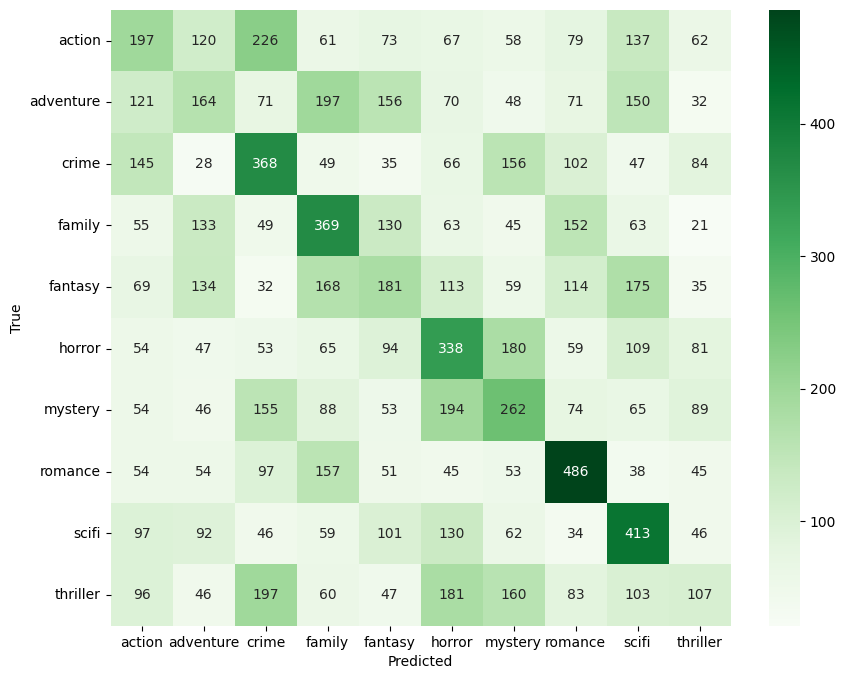

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# compute confusion matrix
cf = confusion_matrix(y_true=y_test, y_pred=y_pred)

#confusion matrix plot with labels as defined with dictionary "genre_mapping"
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cf, annot=True, cmap="Greens", fmt='g',
                      xticklabels=[genre_mapping[i] for i in range(len(genre_mapping))],
                      yticklabels=[genre_mapping[i] for i in range(len(genre_mapping))])
plt.xlabel("Predicted")
plt.ylabel("True")

# rotate labels on y axis
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.show()
